MODEL SELECTION AND EVALUATION: Part 1

In [159]:


from fastai.data.transforms import get_image_files
import fastai.data.transforms as fdt
from fastai.data.transforms import RandomSplitter, parent_label
from fastai.data.block import DataBlock
from fastai.vision.core import PILImage
from fastai.vision.data import ImageBlock, CategoryBlock
from fastai.vision.augment import Resize
from fastai.vision.learner import vision_learner
from torchvision.models.resnet import resnet18
from torchvision import models
from fastai.metrics import error_rate
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


import src.constants as cn
import src.util as util

import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import to_categorical, set_random_seed
import seaborn as sns
from typing import Optional, List

Lecture 3: Statistical Methods (Nicoleta & Joe) - May 1
Real-world story about challenges/lessons learned to motivate the rest of the discussion (Nicoleta)
Generalizability
Transferability
Definitions
Model distribution (Nicoleta)
Comparison to simpler methods (joe)
Digits recognition by linear regression
Conversion from deep learning to simpler methods
Types of problems in empirical modeling
Cross-validation & data splitting (joe)
More on balancing data. Choice of training vs. test data. (SMOT? synthetic minority ? technique)
Want uncorrelated data
Feature engineering
Less used in deep learning for image data but can be helpful
How to structure data
Reproducibility
Evaluation (metrics, etc. – based on experimental design)


# Data Acquisition & Curation

## Modeling in fastai

In [2]:
util.makeDigitDirs(train_count=100, sub_dirs=["0", "1", "3", "5"])

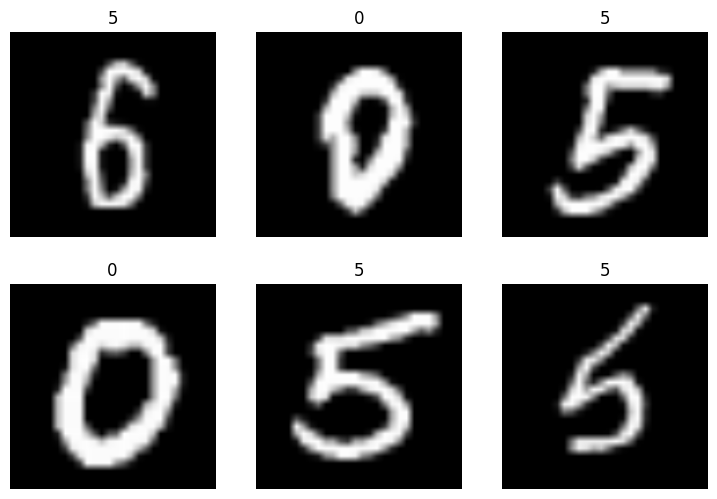

In [3]:
train_path = os.path.join(cn.DATA_MNIST_SMALL, cn.TRAINING)
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(train_path)

dls.show_batch(max_n=6)

In [4]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
#learn = vision_learner(dls, models.efficientnet_v2_m, metrics=error_rate)
learn.fit(2)  # Number of epochs
# Output?: epoch, last is time, others are training loss?

[0, 1.223388433456421, 1.2084020376205444, 0.4124999940395355, '00:01']
[1, 0.6803193092346191, 0.4704741835594177, 0.20000000298023224, '00:00']


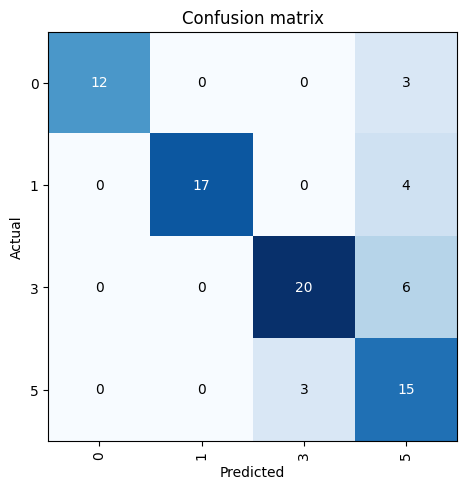

In [5]:
from fastai.interpret import Interpretation, ClassificationInterpretation
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [6]:
# The output of preds is the probability of each class that are concatenated across the test datasets.
test_folder = os.path.join(cn.DATA_MNIST_SMALL, cn.TESTING)
files = get_image_files(test_folder)
test_dl = learn.dls.test_dl(files)
preds = learn.get_preds(dl=test_dl)

In [7]:
preds[0][-1]

tensor([8.3850e-07, 1.4059e-08, 6.7141e-04, 9.9933e-01])

# Modeling in Keras

In [102]:
set_random_seed(2222)
from sklearn.datasets import make_blobs
X, y = make_blobs(centers=3, cluster_std=3)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

In [179]:
np.shape(X_train), np.shape(y_train)

((50, 2), (50,))

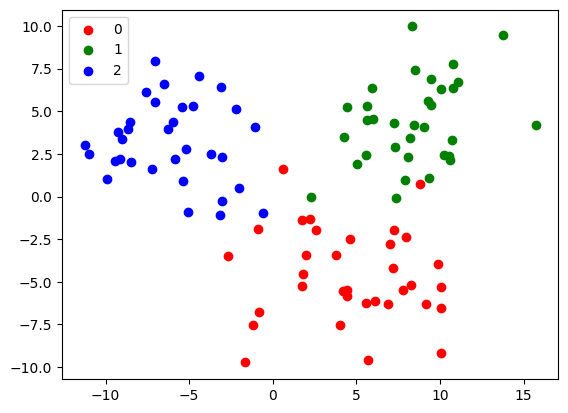

In [103]:
colors = ["r", "g", "b"]
for y_cls in range(3):
    idx = y == y_cls
    Xp = X[idx, :]
    plt.scatter(Xp[:, 0], Xp[:, 1], color=colors[y_cls])
plt.legend(["0", "1", "2"])

In [104]:
model = keras.Sequential(
    [
        keras.Input(shape=(X_train.shape[-1],)),
        layers.Dense(8, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(3, activation="softmax"),
    ]
)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

In [105]:
categorical_y_train = to_categorical(y_train)
print(y_train[0])
print(categorical_y_train[0])

2
[0. 0. 1.]


In [106]:
history = model.fit(X_train, categorical_y_train, epochs=10, batch_size=5,
                    verbose=0)

In [107]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 8)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 440 (1.72 KB)

 Trainable params: 219 (876.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 221 (884.00 B)

In [108]:
y_predict = model.predict(X_test).argmax(axis=1)
from sklearn.metrics import accuracy_score, balanced_accuracy_score
print(accuracy_score(y_test, y_predict))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
0.6


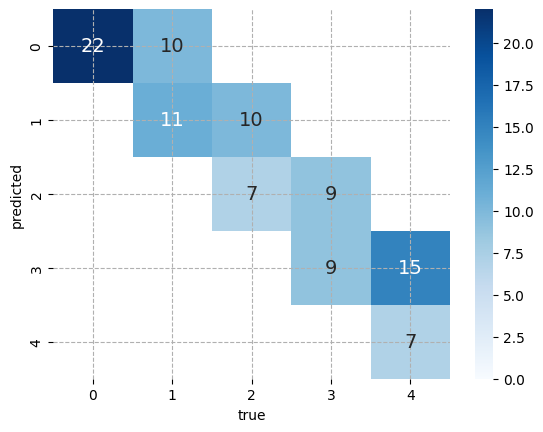

In [149]:
def plotConfusionMatrix(y_true:np.ndarray[int], y_pred:np.ndarray[int]):
    """
    Plots the confusion matrix for the classifications.

    Args:
        y_true: True labels
        y_pred: Predicted labels
    """
    num_label = len(set(y_true))
    mat = tf.math.confusion_matrix(y_true, y_pred)
    mask_mat = np.repeat(True, num_label*num_label)
    mask_mat = np.reshape(mask_mat, (num_label, num_label))
    for yt in range(num_label):
        for yp in range(num_label):
            matches = [y_true[n]==yt and y_pred[n]==yp for n in range(len(y_true))]
            count = np.sum(matches)
            mask_mat[yt, yp] = count == 0
            #label_mat[yt, yp] = str(count) if count > 0 else ""
    #
    _ = sns.heatmap(np.transpose(mat), cmap="Blues", annot=True,
                    annot_kws={'fontsize': 14}, mask=np.transpose(mask_mat),
                 vmin=0)
    plt.grid(linestyle="--")
    plt.ylabel("predicted")
    plt.xlabel("true")
    plt.show()

# Tests
y_true = np.random.randint(0, 5, 100)
y_pred = y_true + np.random.randint(-1, 1, 100)
y_pred = np.maximum(y_pred, 0)
plotConfusionMatrix(y_true, y_pred)

# Image processing with sklearn and keras

1. Reducing image size and making them uniform
2. Filtering

## Image access

In [116]:
util.makeDigitDirs(train_count=100, sub_dirs=["0", "1"])
train_path = os.path.join(cn.DATA_MNIST_SMALL, cn.TRAINING, "0")
ffiles = os.listdir(train_path)
digit_path = os.path.join(train_path, ffiles[0])
digit_img = Image.open(digit_path)
digit_img.show()

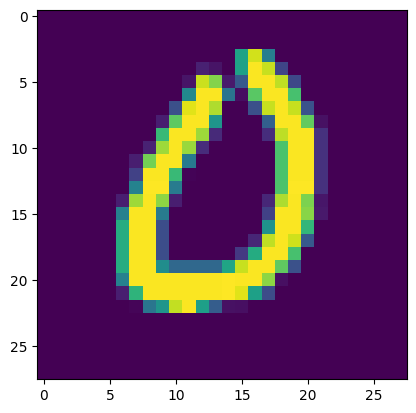

In [121]:
digit_arr = np.asarray(digit_img)
plt.imshow(digit_img)

In [152]:
np.shape(digit_arr)

(28, 28)

## Construct full data of features (X) and labels (y)

In [150]:
# Build training (X_train, y_train) and test (X_test, y_test) data
util.makeDigitDirs(train_count=2, sub_dirs=["0", "1"])
train_path = os.path.join(cn.DATA_MNIST_SMALL, cn.TRAINING, "0")
data = []
ffiles = os.listdir(train_path)
y_data = np.repeat(0, len(ffiles))
for ffile in ffiles:
    path = os.path.join(train_path, ffile)
    img = Image.open(path)
    X_data.extend(np.asarray(img))


In [216]:
def makeDigitData(datatype:str)->(np.ndarray, np.ndarray):
    """
    Uses last construction of the digit data. The image is flattened.

    Args:
        datatype: "testing", "training"
    Returns:
        ndarray: feature matrix
        ndarray: label vector
    """
    base_path = os.path.join(cn.DATA_MNIST_SMALL, datatype)
    ddirs = os.listdir(base_path)
    X_data = []
    y_arr = np.array([])
    for ddir in ddirs:
        this_ddir = os.path.join(base_path, ddir)
        ffiles = os.listdir(this_ddir)
        label_arr = np.repeat(int(ddir), len(ffiles))
        y_arr = np.concatenate((y_arr, label_arr))
        for ffile in ffiles:
            path = os.path.join(this_ddir, ffile)
            img = Image.open(path)
            mat = np.asarray(img)
            arr = mat.flatten()
            X_data.append(arr)
    X_mat = np.stack(X_data)
    return X_mat, y_arr

# Tests
X_mat, y_data = makeDigitData(cn.TRAINING)
num_sample = np.shape(X_mat)[0]
assert(num_sample == np.shape(y_data)[0])
print("OK!")

OK!


In [230]:
arr[0:10]

array([209,  43,  63, 213, 204, 196, 128,  54, 148,  27])

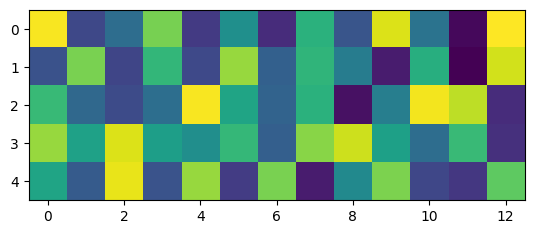

In [235]:
def displayImage(flattened_arr:np.ndarray, nrow=28, ncol=28):
    arr = np.reshape(flattened_arr, (nrow, ncol))
    img = Image.fromarray(arr)
    plt.imshow(img)

# Tests
nrow = 5
ncol = 13
arr = np.uint8(np.random.randint(0, 255, nrow*ncol))
displayImage(arr, nrow=nrow, ncol=ncol)

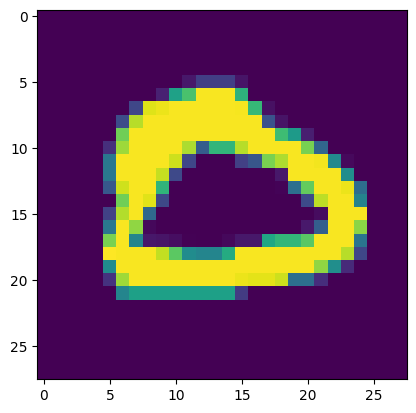

In [243]:
# Create the input data
util.makeDigitDirs(train_count=100, sub_dirs=["0", "1", "2"])
X_training, y_training = makeDigitData(cn.TRAINING)
X_testing, y_testing = makeDigitData(cn.TESTING)
displayImage(X_training[0])

In [237]:
np.shape(X_training), np.shape(y_training)
np.shape(X_testing), np.shape(y_testing)

((40, 784), (40,))

In [244]:
model = keras.Sequential(
    [
        keras.Input(shape=(X_training.shape[-1],)),
        layers.Dense(8, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(3, activation="softmax"),
    ]
)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
categorical_y_train = to_categorical(y_training)
categorical_y_train[102]

array([0., 1., 0.])

In [ ]:
def convertImagesToArrays(dir_path:str)->np.ndarray:
    """
    """

## Model then curate

1. Create a small dataset (1000 images) with 3 digits.
2. Evaluate quality

# 